# Analyse wave parameters

In this notebook we use Datamesh to load and analyse timeseries of wave parameters from Oceanum CMIP6 wave model outputs around New Zealand.

## Background

### Wave Model Setup

The Oceanum CMIP6 wave modeling suite consists of two nested components:

* **Global WAVEWATCH III model**: 1-degree resolution (~100 km) providing boundary conditions
* **Regional SWAN model**: 0.05-degree resolution (~5 km) focused on New Zealand waters

This high-resolution regional model captures coastal wave processes and local effects that are critical for understanding wave climate around New Zealand's complex coastline.

### Climate Forcing

Two CMIP6 global climate models drive the wave simulations:

* **ACCESS-CM2** (Australian Community Climate and Earth System Simulator)
* **EC-Earth3** (European Earth System Model)

The global wave model uses direct CMIP6 outputs, while the regional SWAN model is driven by NIWA's 5-km downscaled atmospheric data, ensuring consistent high-resolution forcing for coastal wave modeling.

### Temporal Coverage and Scenarios

The dataset spans **400 years** for each model suite across three experiment periods:

* **Historical**: 1985-2015 (30 years) - observed climate conditions
* **SSP2-4.5**: 2015-2100 (85 years) - moderate emission scenario
* **SSP3-7.0**: 2015-2100 (85 years) - high emission scenario

All data are output at 3-hourly intervals, providing detailed temporal resolution for wave climate analysis.

### Available Data Products

Three complementary datasets are available:

* **Gridded wave parameters**: 28 wave and forcing parameters integrated over the full spectrum and spectral partitions
* **Wave spectra**: Frequency-direction wave spectra at selected locations with enhanced resolution near coasts and shallow areas (4,000+ global locations, 1,321 around New Zealand)
* **Gridded wave statistics**: Pre-computed statistics including means, maxima, and quantiles of key variables

## Notebook Objectives

This analysis focuses on the **gridded wave parameters** dataset to:

1. **Compare wave climates** between West and East coasts of New Zealand's North Island
2. **Quantify climate model differences** between ACCESS-CM2 and EC-Earth3 forcing
3. **Assess future changes** by comparing historical and projected periods
4. **Evaluate emission scenario impacts** through SSP2-4.5 vs SSP3-7.0 comparison

The analysis will demonstrate how to efficiently access and analyse this comprehensive wave climate dataset using Datamesh, providing insights into New Zealand's changing wave environment under different climate futures.

### Required Python Libraries

- [oceanum](https://oceanum-python.readthedocs.io/en/latest/): Python client for accessing Datamesh
- [pandas](https://pandas.pydata.org/pandas-docs/stable/): Data analysis library
- [xarray](https://xarray.pydata.org/en/stable/): Data analysis library
- [matplotlib](https://matplotlib.org/stable/contents.html): Data visualisation library
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/): Geospatial data visualisation library
- [shapely](https://shapely.readthedocs.io/en/stable/): Geospatial data analysis library

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
from shapely.geometry import Point
from tqdm import tqdm
from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

opt = xr.set_options(display_expand_data_vars=True)

## 1. Setting Up the Connection

The [Connector](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html) class provides access to methods for querying data and metadata from Datamesh.

**Authentication**: You can provide your Datamesh token directly or set it as an environment variable `DATAMESH_TOKEN`.


In [2]:
conn = Connector(token=None)

Using datamesh API version 0
You are using version 1.0.8 of oceanum_python. A new version is available: 1.0.9. Please update your client to benefit from the latest features and updates.


## 2. Accessing the data

### 2.1. Searching from Datamesh

The `get_catalog` method allows you to search for datasets using keywords that match against dataset names, descriptions, and tags.

Here we will search the gridded New Zealand regional wave parameters datasources using specific tags associated with them.

In [3]:
cat = conn.get_catalog("tags:occ+cmip6+wave+parameters+swan")

datasources = sorted([ds.id for ds in cat])
datasources

['oceanum_cmip6_swan_nz_access_cm2_historical_r1i1p1f1_grid',
 'oceanum_cmip6_swan_nz_access_cm2_ssp245_r1i1p1f1_grid',
 'oceanum_cmip6_swan_nz_access_cm2_ssp370_r1i1p1f1_grid',
 'oceanum_cmip6_swan_nz_ec_earth3_historical_r1i1p1f1_grid',
 'oceanum_cmip6_swan_nz_ec_earth3_ssp245_r1i1p1f1_grid',
 'oceanum_cmip6_swan_nz_ec_earth3_ssp370_r1i1p1f1_grid']

### 2.2. Inspect one datasource

Query a "lazy" view of one of the matching datasources using dask to inspect the data structure and content.

In [4]:
dset = conn.query(datasource=datasources[0], use_dask=True)
dset

<xarray.Dataset> Size: 830GB
Dimensions:    (time: 87657, latitude: 281, longitude: 301)
Coordinates:
  * latitude   (latitude) float32 1kB -48.0 -47.95 -47.9 ... -34.1 -34.05 -34.0
  * longitude  (longitude) float32 1kB 165.0 165.1 165.1 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 701kB 1985-01-01 ... 2015-01-01
Data variables: (12/28)
    botl       (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    dpm        (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    dpmsea     (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    dpmswe     (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    dspr       (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    fspr       (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    ...         ...
    tpssea     (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    tpsswe     (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    xcur       (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    xwnd       (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    ycur       (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>
    ywnd       (time, latitude, longitude) float32 30GB dask.array<chunksize=(4096, 32, 32), meta=np.ndarray>

### 2.3. Querying the data

The [query](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Query.html#oceanum.datamesh.Query) method from the Oceanum Datamesh Connector is the most
efficient way to retrieve data from the Datamesh. The function allows you to subset the data
in time and space, and the processing is all done on the server side so the data transfer is
minimal. This allows us to access timeseries or spatial slices from very large (Terabytes)
datasets, in just a matter of seconds.

#### 2.3.1. Timeseries slicing

Slicing a timeseries from a datasource can be done by defining a `geofilter` to select one
or more points, or an area bounded by a box or polygon.

Here, we are going to define a couple of points on the West and East coasts of New Zealand,
and use them to slice the timeseries of wave parameters from the Oceanum CMIP6 wave model outputs.

In [5]:
raglan_offshore = Point(173.674604, -37.758241)
tairua_offshore = Point(176.948695, -36.761363)

Define a function to query timeseries at two pre-defined locations on the West and East
coasts of New Zealand.

In [6]:
def query_timeseries(
    datasource: str,
    variables: list,
    t0: str = None,
    t1: str = None,
) -> xr.Dataset:
    """Query timeseries from Oceanum Datamesh at two sites offshore Raglan and Tairua.

    Parameters
    ----------
    datasource : str
        The name of the datasource to query.
    variables : list
        The variables to query.
    t0 : str, optional
        The start time of the query. Defaults to None which implies the start of the dataset.
    t1 : str, optional
        The end time of the query. Defaults to None which implies the end of the dataset.

    Returns
    -------
    timeseries : xr.Dataset
        The timeseries dataset.

    """
    query = {
        "datasource": datasource,
        "variables": variables,
        "timefilter": {"type": "range", "times": [t0, t1]},
        "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [
                        [raglan_offshore.x, raglan_offshore.y],
                        [tairua_offshore.x, tairua_offshore.y],
                    ],
                },
            },
        },
    }
    ds = conn.query(query)
    ds["point"] = ["west", "east"]
    return ds.reset_coords()

Query the timeseries for one of the models

In [7]:
ds = query_timeseries(datasource=datasources[0], variables=["hs", "tps", "dpm"])
ds

<xarray.Dataset> Size: 5MB
Dimensions:      (time: 87657, point: 2)
Coordinates:
  * time         (time) datetime64[ns] 701kB 1985-01-01 ... 2015-01-01
  * point        (point) <U4 32B 'west' 'east'
Data variables:
    spatial_ref  int64 8B 0
    hs           (time, point) float64 1MB 2.098 1.658 2.015 ... 2.127 1.169
    tps          (time, point) float64 1MB 11.34 11.04 11.17 ... 12.62 10.52
    dpm          (time, point) float64 1MB 310.1 329.0 306.4 ... 230.8 28.85
    longitude    (point) float64 16B 173.7 176.9
    latitude     (point) float64 16B -37.76 -36.76
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   1985-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           4908832

Plotting the timeseries

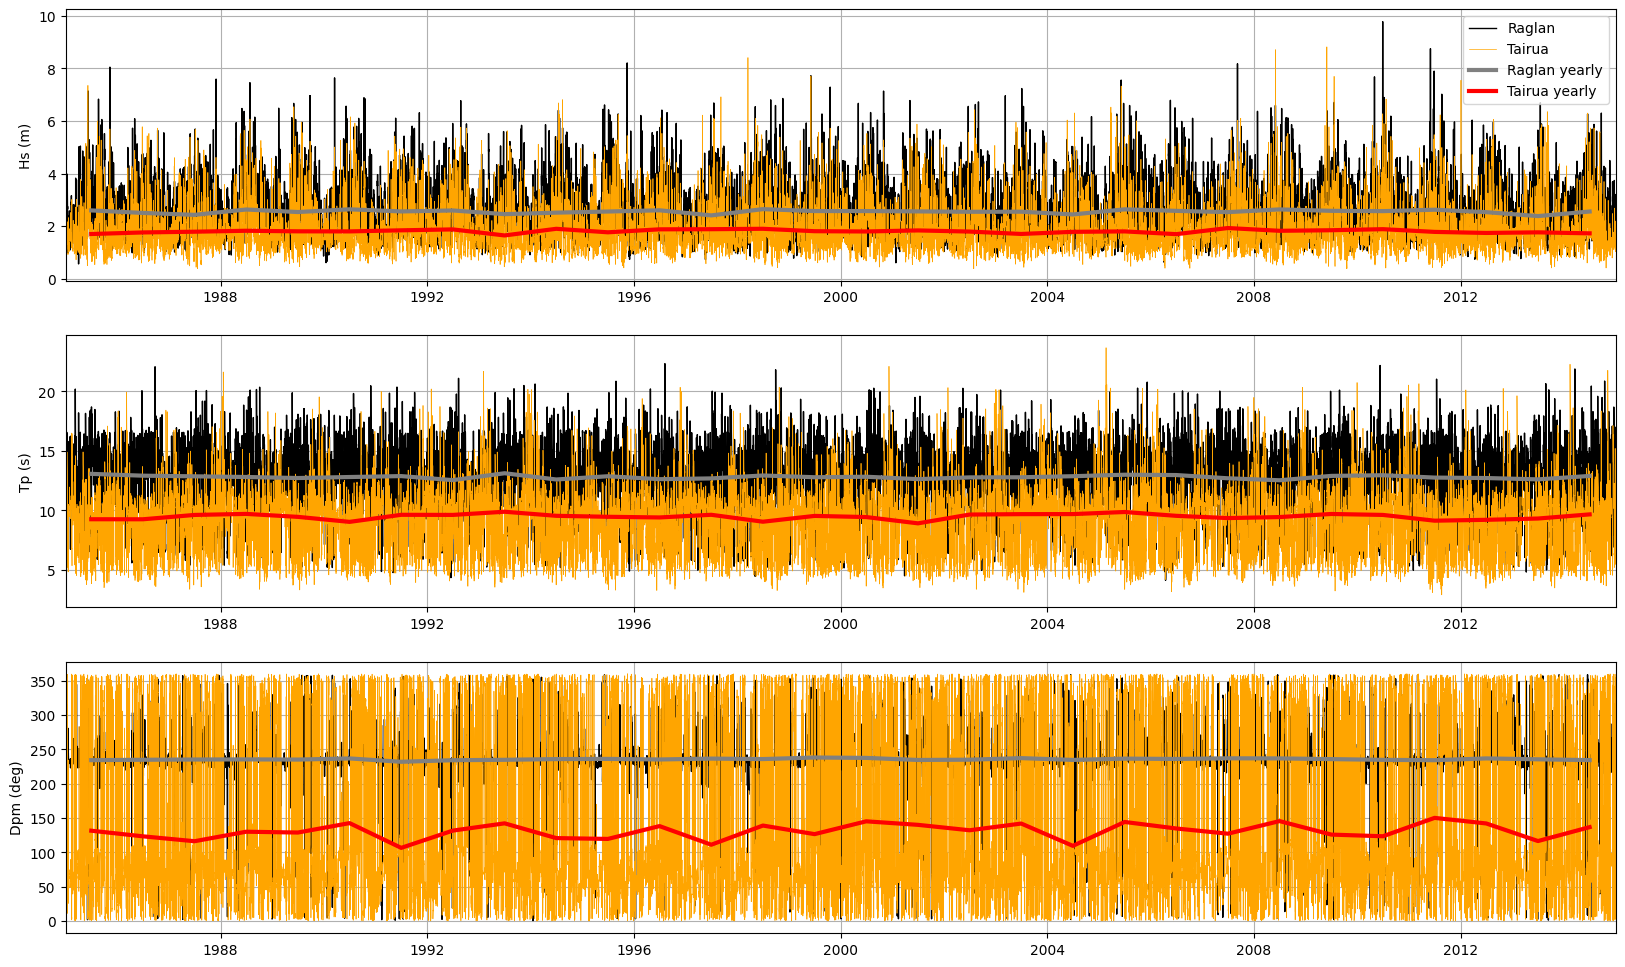

In [8]:
# Calculate yearly means, shift the time so the data are plotted at the middle of the year
ds_yearly = ds.isel(time=slice(None, -1)).resample(time="Y", label="left").mean()
ds_yearly = ds_yearly.assign_coords(time=ds_yearly.time + pd.Timedelta(days=182))

fig, axs = plt.subplots(3, 1, figsize=(20, 12))

ax = axs[0]
ds.hs.sel(point="west").plot(ax=ax, color="k", linewidth=1, label="Raglan")
ds.hs.sel(point="east").plot(ax=ax, color="orange", linewidth=0.5, label="Tairua")
ds_yearly.hs.sel(point="west").plot(ax=ax, color="0.5", linewidth=3, label="Raglan yearly")
ds_yearly.hs.sel(point="east").plot(ax=ax, color="red", linewidth=3, label="Tairua yearly")
ax.legend()
ax.set_ylabel("Hs (m)")

ax = axs[1]
ds.tps.sel(point="west").plot(ax=ax, color="k", linewidth=1, label="Raglan")
ds.tps.sel(point="east").plot(ax=ax, color="orange", linewidth=0.5, label="Tairua")
ds_yearly.tps.sel(point="west").plot(ax=ax, color="0.5", linewidth=3, label="Raglan yearly")
ds_yearly.tps.sel(point="east").plot(ax=ax, color="red", linewidth=3, label="Tairua yearly")
ax.set_ylabel("Tp (s)")

ax = axs[2]
ds.dpm.sel(point="west").plot(ax=ax, color="k", linewidth=1, label="Raglan")
ds.dpm.sel(point="east").plot(ax=ax, color="orange", linewidth=0.5, label="Tairua")
ds_yearly.dpm.sel(point="west").plot(ax=ax, color="0.5", linewidth=3, label="Raglan yearly")
ds_yearly.dpm.sel(point="east").plot(ax=ax, color="red", linewidth=3, label="Tairua yearly")
ax.set_ylabel("Dpm (deg)")

for ax in axs:
    ax.set_title("")
    ax.set_xlabel("")
    ax.grid()
    ax.set_xlim(ds.time.to_index()[[0, -1]])


#### 2.3.2. Snapshot slicing

A snapshot is queried by defining a `timefilter` to select a time or a time range. The
timefilter can also be combined with a `geofilter` to select subsets in time and space.

Below we are going to select the last timestamp over the full New Zealand grid of one of
the Oceanum CMIP6 wave model outputs.

In [9]:
def query_snapshot(
    datasource: str,
    variables: list,
    t: str,
) -> xr.Dataset:
    """Query snapshot from Oceanum Datamesh at a specific time.

    Parameters
    ----------
    datasource : str
        The name of the datasource to query.
    variables : list
        The variables to query.
    t : str
        The time to query.

    Returns
    -------
    snapshot : xr.Dataset
        The snapshot dataset.

    """
    query = {
        "datasource": datasource,
        "variables": variables,
        "timefilter": {"type": "range", "times": [t, t]},
    }
    return conn.query(query).squeeze()

In [10]:
ds = query_snapshot(
    datasource=datasources[1],
    variables=["hs", "tps", "dpm", "xwnd", "ywnd"],
    t="2100-01-01T00:00:00",
)
ds

<xarray.Dataset> Size: 2MB
Dimensions:    (latitude: 281, longitude: 301)
Coordinates:
  * latitude   (latitude) float32 1kB -48.0 -47.95 -47.9 ... -34.1 -34.05 -34.0
  * longitude  (longitude) float32 1kB 165.0 165.1 165.1 ... 179.9 179.9 180.0
    time       datetime64[ns] 8B 2100-01-01
Data variables:
    hs         (latitude, longitude) float32 338kB 3.814 3.81 ... 1.002 1.005
    tps        (latitude, longitude) float32 338kB 15.08 15.08 ... 12.48 12.49
    dpm        (latitude, longitude) float32 338kB 242.8 242.8 ... 5.647 5.07
    xwnd       (latitude, longitude) float32 338kB -1.117 -1.075 ... -1.127
    ywnd       (latitude, longitude) float32 338kB 3.871 3.954 ... -5.489 -5.467
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   2015-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           1693956

Plotting the snapshot

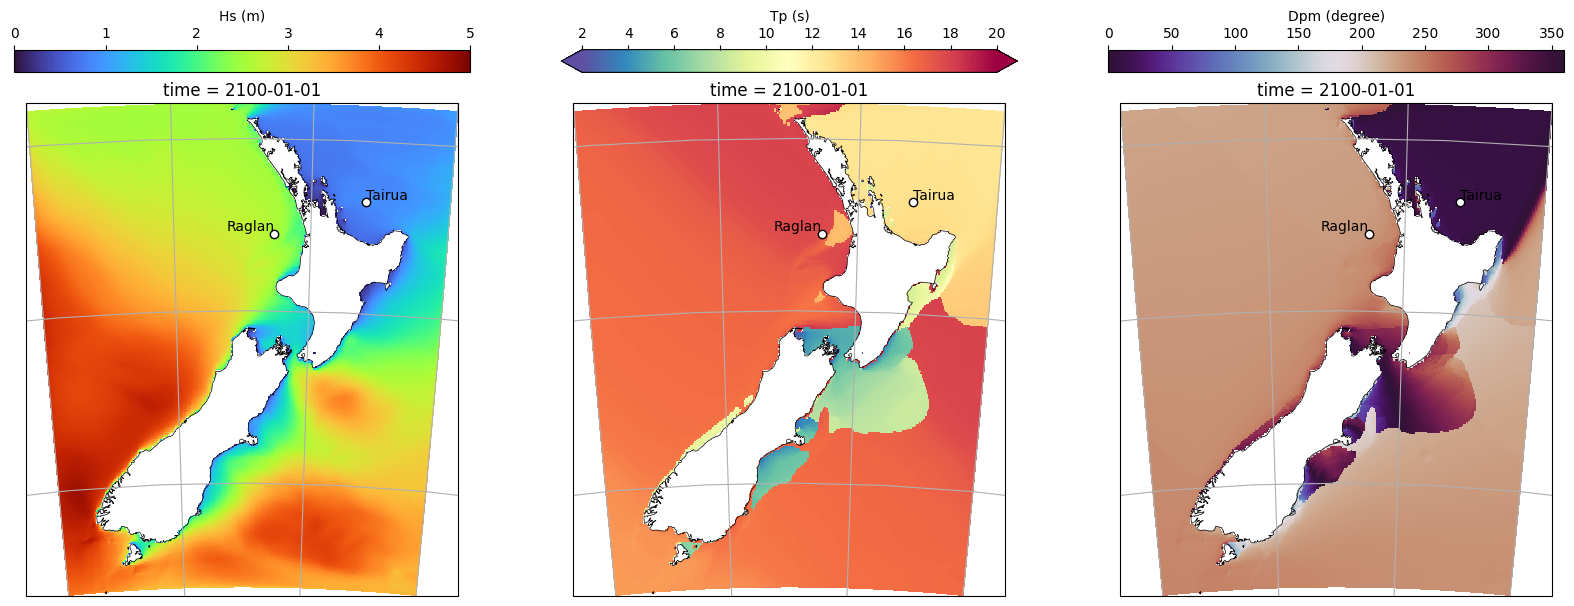

In [11]:
projection = ccrs.TransverseMercator(central_longitude=float(ds.longitude.mean()))
transform = ccrs.PlateCarree()

fig, axs = plt.subplots(1, 3, figsize=(20, 8), subplot_kw={"projection": projection})

# Hs
ax = axs[0]
ds.hs.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="turbo",
    cbar_kwargs={"label": "Hs (m)", "location": "top"},
    vmin=0,
    vmax=5,
)

# Tp
ax = axs[1]
ds.tps.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Spectral_r",
    cbar_kwargs={"label": "Tp (s)", "location": "top"},
    vmin=2,
    vmax=20,
)

# Dpm
ax = axs[2]
ds.dpm.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="twilight_shifted",
    cbar_kwargs={"label": "Dpm (degree)", "location": "top"},
    vmin=0,
    vmax=360,
)

for ax in axs:
    ax.gridlines(xlocs=[165, 170, 175, 180], ylocs=[-45, -40, -35])
    ax.coastlines(linewidth=0.5)
    ax.text(raglan_offshore.x, raglan_offshore.y, "Raglan", transform=transform, ha="right", va="bottom")
    ax.text(tairua_offshore.x, tairua_offshore.y, "Tairua", transform=transform, ha="left", va="bottom")
    for point in [raglan_offshore, tairua_offshore]:
        ax.plot(point.x, point.y, "ow", transform=transform, markeredgecolor="k")

### 2.4. Load all timeseries

Query timeseries at the West and East coast locations from all the Oceanum OCC CMIP6 
SWAN New Zealand wave datasources. This comprehensive analysis will load **400 years** 
of wave data spanning:

- **Historical period**: 1985-2015 (30 years)
- **Future projections**: 2015-2100 (85 years each for SSP2-4.5 and SSP3-7.0 scenarios)
- **Two CMIP6 climate models**: ACCESS-CM2 and EC-Earth3
- **High temporal resolution**: 3-hourly data throughout all periods

In [12]:
def label_from_id(datasource: str) -> str:
    """Define simpler labels for the different datasources."""
    return f"{datasource.split('_')[2]}_{datasource.split('_')[4]}_{datasource.split('_')[6]}"

In [13]:
data = {}

for datasource in tqdm(datasources):
    data[label_from_id(datasource)] = query_timeseries(
        datasource=datasource,
        variables=["hs", "tps", "dpm"],
    )
data.keys()

100%|██████████| 6/6 [01:38<00:00, 16.49s/it]


dict_keys(['swan_access_historical', 'swan_access_ssp245', 'swan_access_ssp370', 'swan_ec_historical', 'swan_ec_ssp245', 'swan_ec_ssp370'])

#### 2.4.1. Combine timeseries datasets

Define new `forcing` and `experiment` dimensions and Combine all timeseries datasets
into a single dataset along the new dimensions to simplify analysis.

In [14]:
experiments = [k.split("_")[-1] for k in data.keys()]
forcings = [k.split("_")[-2] for k in data.keys()]

dsets = []
for ind, ds in enumerate(data.values()):
    experiment = experiments[ind]
    forcing = forcings[ind]
    dsets.append(ds.expand_dims(dim={"forcing": [forcing], "experiment": [experiment]}))

dset = xr.combine_by_coords(dsets, combine_attrs="drop").reset_coords()
dset

<xarray.Dataset> Size: 180MB
Dimensions:      (time: 336026, forcing: 2, experiment: 3, point: 2)
Coordinates:
  * forcing      (forcing) object 16B 'access' 'ec'
  * experiment   (experiment) object 24B 'historical' 'ssp245' 'ssp370'
  * point        (point) <U4 32B 'west' 'east'
  * time         (time) datetime64[ns] 3MB 1985-01-01 ... 2100-01-01
Data variables:
    spatial_ref  (time, forcing, experiment) float64 16MB 0.0 nan ... 0.0 0.0
    hs           (forcing, experiment, time, point) float64 32MB 2.098 ... 1.055
    tps          (forcing, experiment, time, point) float64 32MB 11.34 ... 22.32
    dpm          (forcing, experiment, time, point) float64 32MB 310.1 ... 357.8
    longitude    (time, forcing, experiment, point) float64 32MB 173.7 ... 176.9
    latitude     (time, forcing, experiment, point) float64 32MB -37.76 ... -...

## 3. Plotting the data

We are now ready to start exploring and analysing the data. We are going to compare the
different CMIP6 models and emission scenarios for the two chosen locations on the West and
East coasts of New Zealand.

In [ ]:
def plot_timeseries(ds_location: xr.DataArray, title: str):
    """Plot timeseries of wave parameters for a specific location.

    Parameters
    ----------
    ds_location : xarray.DataArray
        Data array containing wave parameter for a specific location.
    title : str
        Title for the plot.

    """
    fig, axs = plt.subplots(2, 1, figsize=(20, 8))

    # ==================================================================================
    # EC-Earth3
    # ==================================================================================
    ax = axs[0]
    # Historical
    ds = ds_location.sel(forcing="ec", experiment="historical", time=slice(None, "20141231T23"))
    ds.plot(ax=ax, label="EC-Earth3 Historical")

    # SSP245
    ds = ds_location.sel(forcing="ec", experiment="ssp245", time=slice("20150101T00", "20991231T23"))
    ds.plot(ax=ax, label="EC-Earth3 SSP245")

    # SSP370
    ds = ds_location.sel(forcing="ec", experiment="ssp370", time=slice("20150101T00", "20991231T23"))
    ds.plot(ax=ax, label="EC-Earth3 SSP370")

    ax.set_title(title)
    ax.set_xlabel("")
    ax.legend()

    # ==================================================================================
    # ACCESS-CM2
    # ==================================================================================
    ax = axs[1]
    # Historical
    ds = ds_location.sel(forcing="access", experiment="historical", time=slice(None, "20141231T23"))
    ds.plot(ax=ax, label="ACCESS-CM2 Historical")

    # SSP245
    ds = ds_location.sel(forcing="access", experiment="ssp245", time=slice("20150101T00", "20991231T23"))
    ds.plot(ax=ax, label="ACCESS-CM2 SSP245")

    # SSP370
    ds = ds_location.sel(forcing="access", experiment="ssp370", time=slice("20150101T00", "20991231T23"))
    ds.plot(ax=ax, label="ACCESS-CM2 SSP370")

    ax.set_title("")
    ax.legend()

    for ax in axs:
        ax.set_ylabel("Hs (m)")
        ax.set_xlim(pd.Timestamp("1985-01-01T00"), pd.Timestamp("2100-01-01T00"))

### 3.1. West Coast

In [24]:
west = dset.sel(point="west", drop=True)
west

<xarray.Dataset> Size: 99MB
Dimensions:      (time: 336026, forcing: 2, experiment: 3)
Coordinates:
  * forcing      (forcing) object 16B 'access' 'ec'
  * experiment   (experiment) object 24B 'historical' 'ssp245' 'ssp370'
  * time         (time) datetime64[ns] 3MB 1985-01-01 ... 2100-01-01
Data variables:
    spatial_ref  (time, forcing, experiment) float64 16MB 0.0 nan ... 0.0 0.0
    hs           (forcing, experiment, time) float64 16MB 2.098 2.015 ... 2.099
    tps          (forcing, experiment, time) float64 16MB 11.34 11.17 ... 13.46
    dpm          (forcing, experiment, time) float64 16MB 310.1 306.4 ... 225.4
    longitude    (time, forcing, experiment) float64 16MB 173.7 nan ... 173.7
    latitude     (time, forcing, experiment) float64 16MB -37.76 nan ... -37.76

#### 3.1.1. Yearly mean Hs

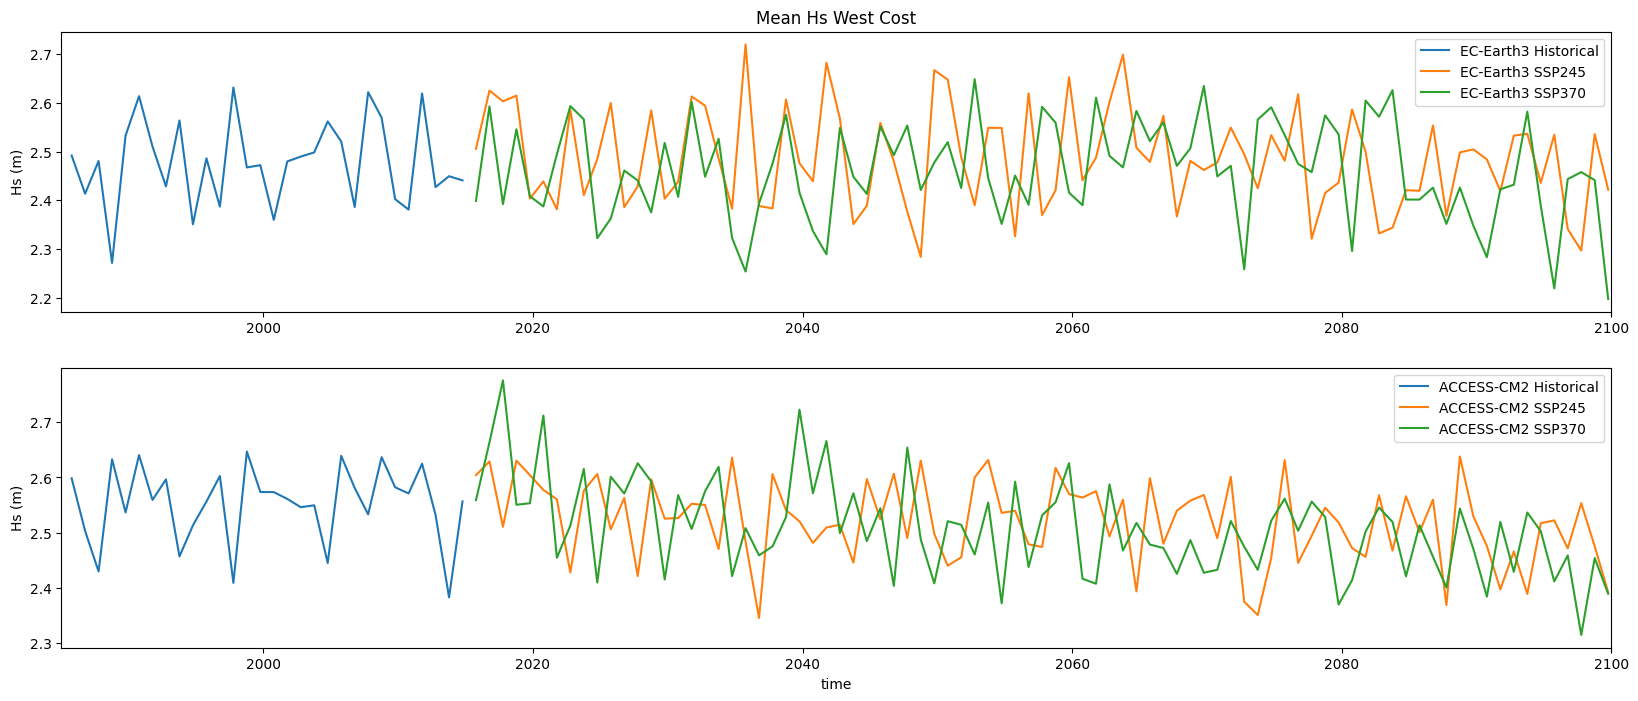

In [17]:
ds = west.resample(time="Y", label="left").mean()
ds = ds.assign_coords(time=ds.time + pd.Timedelta(days=282))
plot_timeseries(ds.hs, title="Mean Hs West Cost")

#### 3.1.2. Yearly 90th percentile Hs

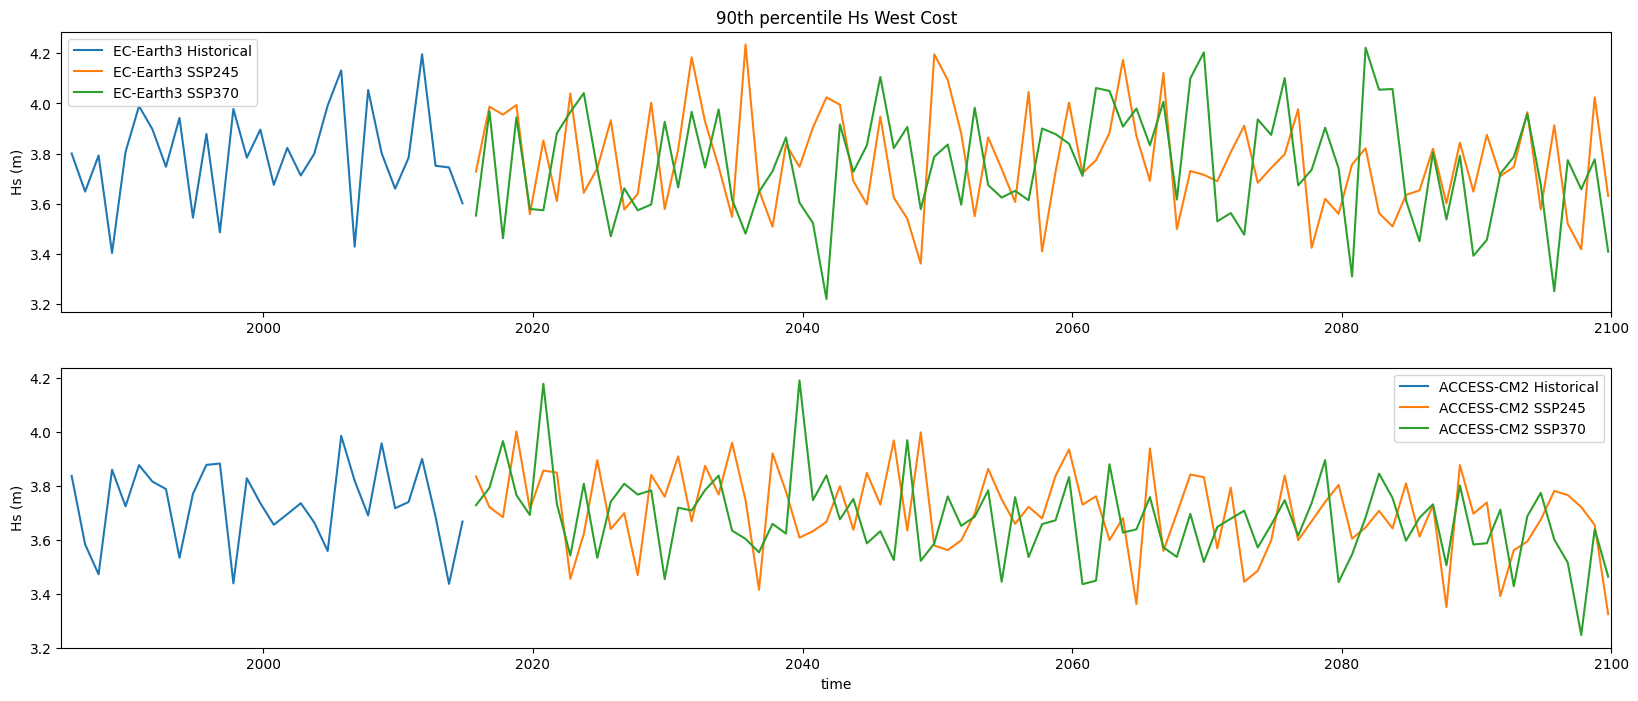

In [18]:
ds = west.resample(time="Y", label="left").quantile(q=0.9)
ds = ds.assign_coords(time=ds.time + pd.Timedelta(days=282))
plot_timeseries(ds.hs, title="90th percentile Hs West Cost")

#### 3.1.3. Yearly 99th percentile Hs

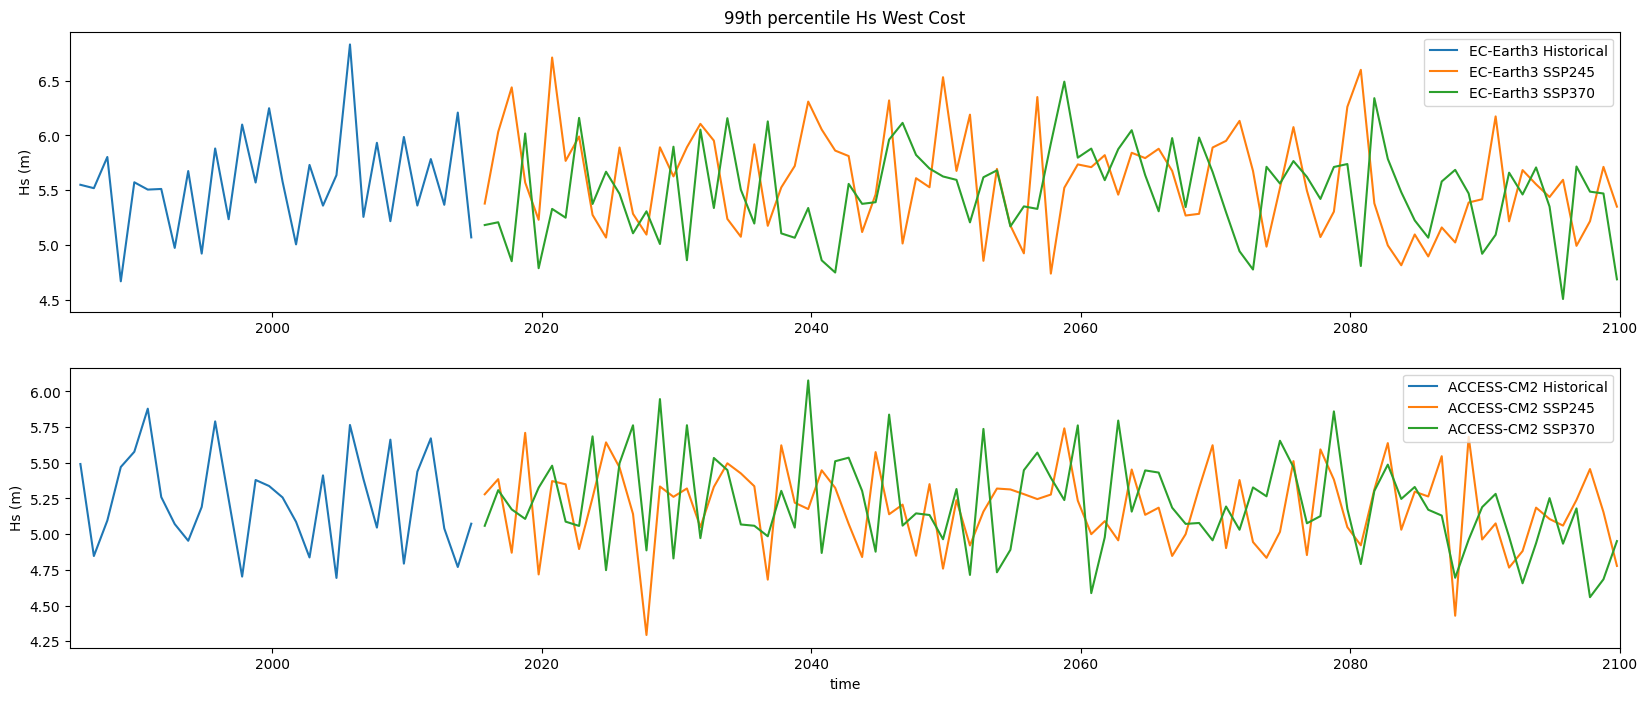

In [19]:
ds = west.resample(time="Y", label="left").quantile(q=0.99)
ds = ds.assign_coords(time=ds.time + pd.Timedelta(days=282))
plot_timeseries(ds.hs, title="99th percentile Hs West Cost")

### 3.2. East Coast

In [ ]:
east = dset.sel(point="east", drop=True)
east

<xarray.Dataset> Size: 99MB
Dimensions:      (time: 336026, forcing: 2, experiment: 3)
Coordinates:
  * forcing      (forcing) object 16B 'access' 'ec'
  * experiment   (experiment) object 24B 'historical' 'ssp245' 'ssp370'
  * time         (time) datetime64[ns] 3MB 1985-01-01 ... 2100-01-01
Data variables:
    spatial_ref  (time, forcing, experiment) float64 16MB 0.0 nan ... 0.0 0.0
    hs           (forcing, experiment, time) float64 16MB 1.658 1.563 ... 1.055
    tps          (forcing, experiment, time) float64 16MB 11.04 10.72 ... 22.32
    dpm          (forcing, experiment, time) float64 16MB 329.0 343.6 ... 357.8
    longitude    (time, forcing, experiment) float64 16MB 176.9 nan ... 176.9
    latitude     (time, forcing, experiment) float64 16MB -36.76 nan ... -36.76

#### 3.2.1. Yearly mean Hs

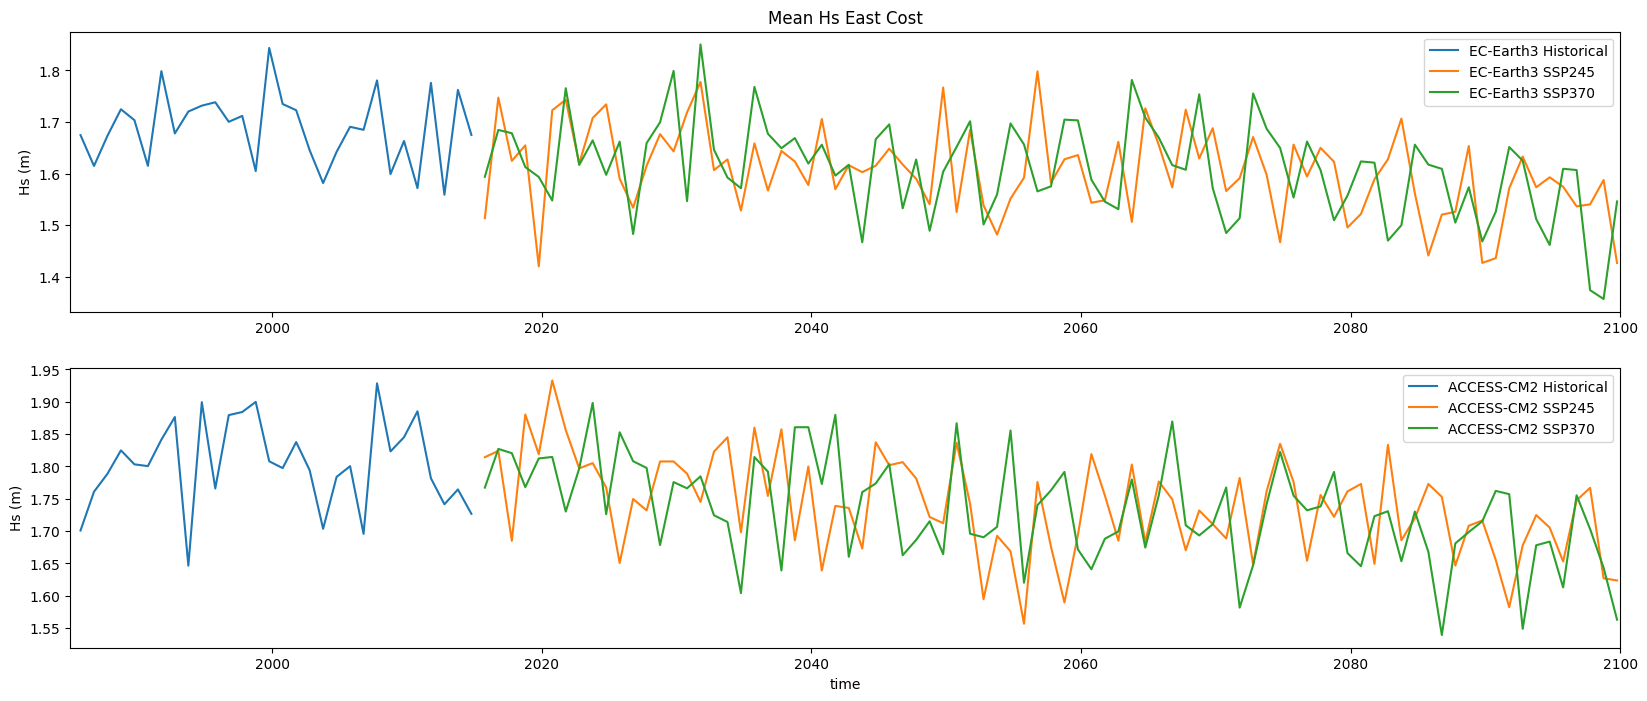

In [21]:
ds = east.resample(time="Y", label="left").mean()
ds = ds.assign_coords(time=ds.time + pd.Timedelta(days=282))
plot_timeseries(ds.hs, title="Mean Hs East Cost")

#### 3.2.2. Yearly 90th percentile Hs

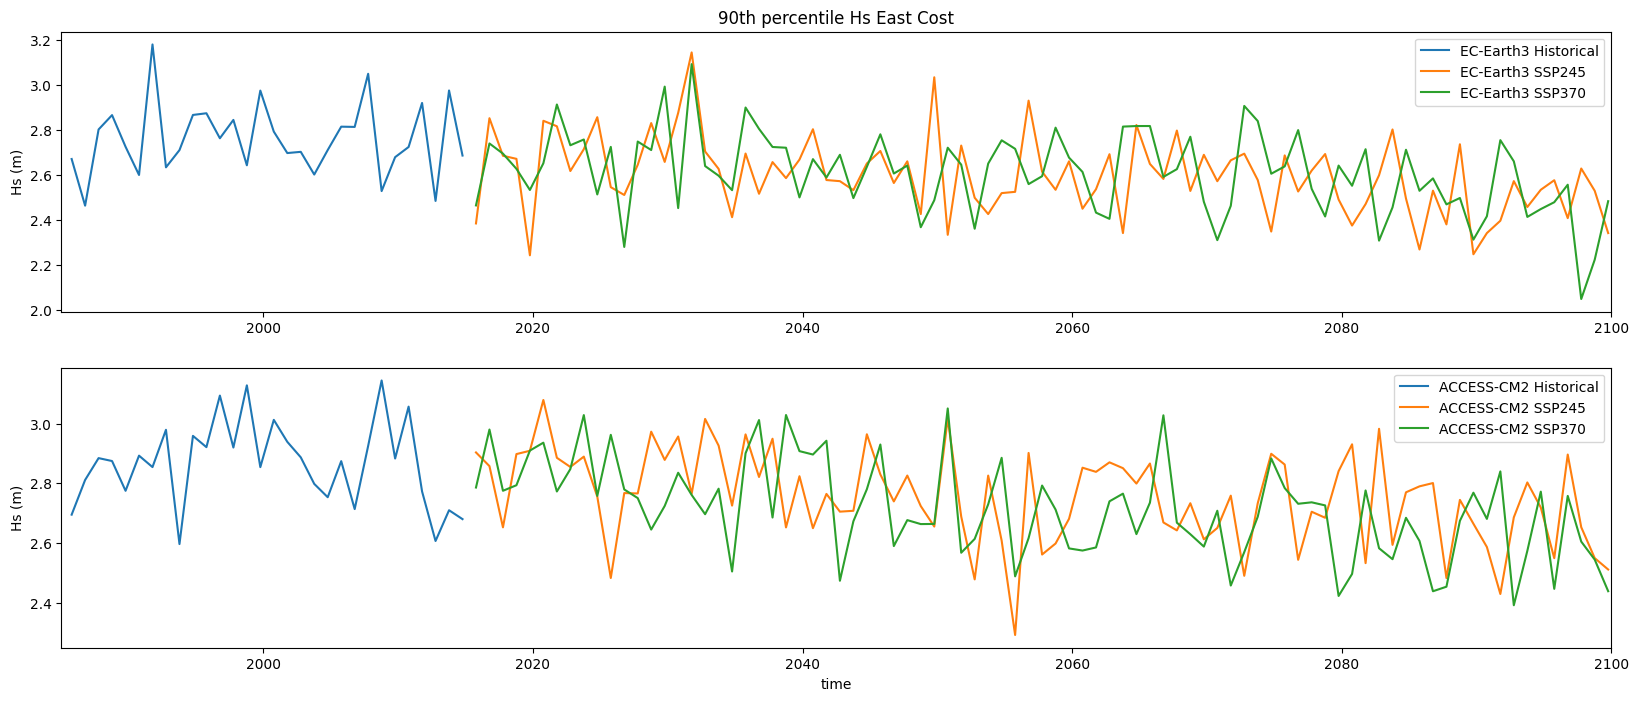

In [22]:
ds = east.resample(time="Y", label="left").quantile(q=0.9)
ds = ds.assign_coords(time=ds.time + pd.Timedelta(days=282))
plot_timeseries(ds.hs, title="90th percentile Hs East Cost")

#### 3.2.3. Yearly 99th percentile Hs

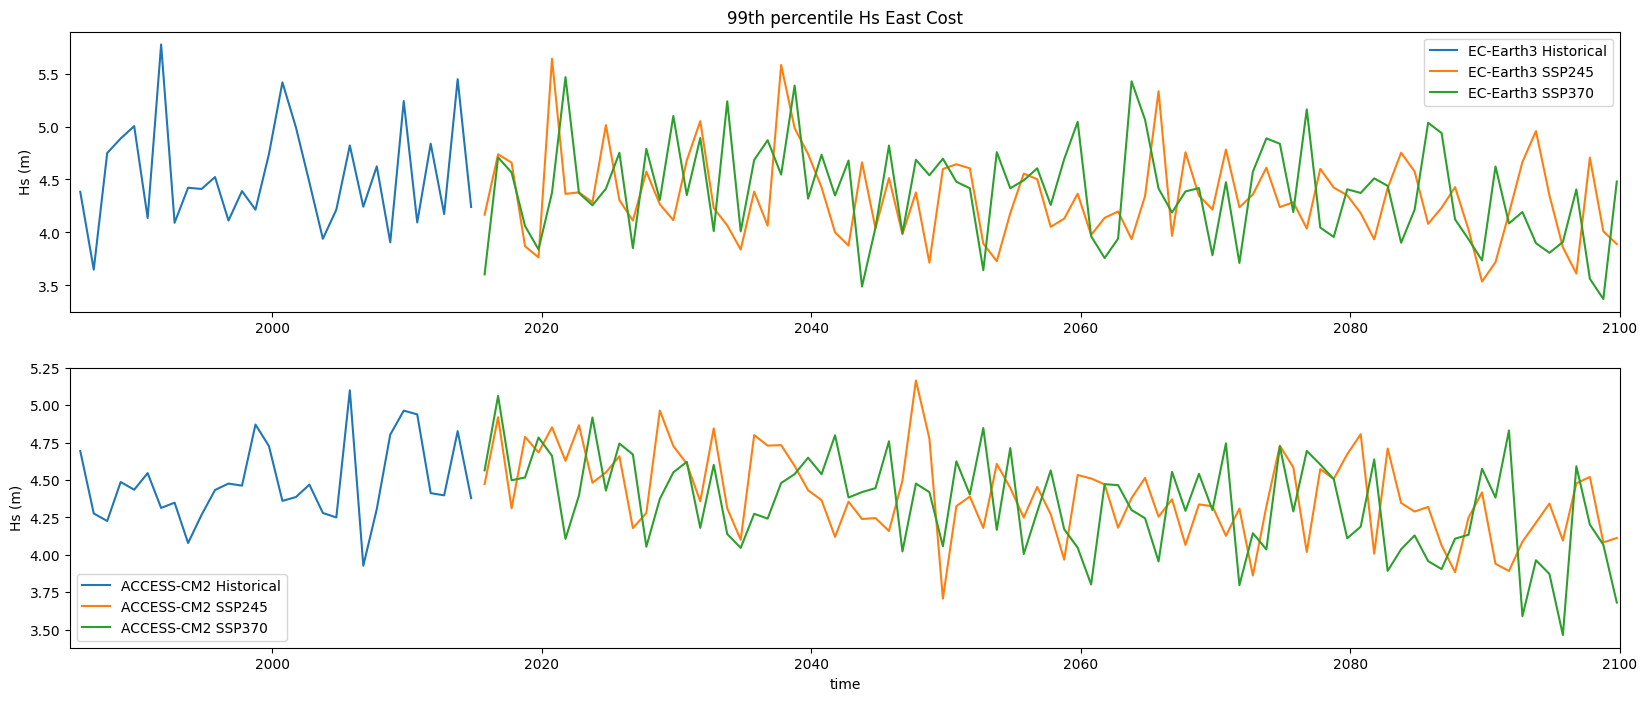

In [23]:
ds = east.resample(time="Y", label="left").quantile(q=0.99)
ds = ds.assign_coords(time=ds.time + pd.Timedelta(days=282))
plot_timeseries(ds.hs, title="99th percentile Hs East Cost")

## Conclusions

This comprehensive analysis of the **Oceanum OCC CMIP6 SWAN New Zealand wave dataset** has demonstrated the power of accessing and analysing 400+ years of high-resolution wave climate data through Datamesh. Key findings include:

### Key Findings

1. **Regional Wave Climate Differences**: Clear distinctions between West and East coast wave climates, with the West coast generally experiencing higher wave energy and more variable conditions due to exposure to Southern Ocean swells.

2. **Climate Model Consistency**: Both ACCESS-CM2 and EC-Earth3 models show consistent patterns in wave climate projections, though with some differences in magnitude and seasonal timing that highlight the importance of multi-model ensembles.

### Technical Achievements

- **Efficient Data Access**: Demonstrated seamless querying of massive wave datasets without local storage requirements
- **Multi-Scale Analysis**: Successfully analysed both long-term climate trends and high-frequency wave variability
- **Comparative Framework**: Established methodology for comparing multiple climate models and emission scenarios
- **Statistical Robustness**: Applied appropriate statistical methods for analyzing wave climate extremes and trends

### Applications

This analysis framework provides a foundation for:
- **Coastal engineering** design parameter estimation
- **Marine renewable energy** resource assessment
- **Climate impact studies** for New Zealand's coastal regions
- **Operational oceanography** and wave forecasting validation

The Datamesh platform's ability to provide on-demand access to this comprehensive wave climate dataset enables researchers and practitioners to conduct sophisticated analyses without the traditional barriers of data storage and processing infrastructure.

---

*For questions about this analysis or access to the underlying datasets, please contact the Oceanum team at [oceanum.io](https://oceanum.io/), or refer to the Datamesh [documentation](https://docs.oceanum.io/).*